# Validation of 3D reconstruct sturcture

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
 
import re

sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D

import importlib
importlib.reload(Cell3D)
import matplotlib.pyplot as plt
import seaborn as sns

import concurrent.futures
import tqdm
from sklearn.cluster import DBSCAN

from CHARMtools import spatialstat
import multiprocessing
from functools import partial

from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy import stats
from scipy.spatial import ConvexHull

plt.rcParams['pdf.use14corefonts'] = True
# use retina display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# remove grid
plt.rcParams['axes.grid'] = False

/tmp/ipykernel_2144458/2071209377.py:40: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2].reset_index(drop=True)

## Rabl

In [3]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [200000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [01:00<00:00, 11.89it/s]


In [4]:
def _calc_random_diff(df_group):
    unique_coords_df = df_group[['x','y','z']].drop_duplicates()
    if len(unique_coords_df) < 2:
        return np.array([0.0, 0.0, 0.0])
    else:
        sampled_points = unique_coords_df.sample(2, replace=False, random_state=42)
        p1 = sampled_points.iloc[0].values
        p2 = sampled_points.iloc[1].values
        return p1 - p2

def _safe_normalize(vec):
    norm = np.linalg.norm(vec)
    if norm == 0:
        return np.array([0.0, 0.0, 0.0])
    return vec / norm

dists = []
dists_random = []
for cell in tqdm.tqdm(cells):
    vec = cell.get_data().groupby('chrom',observed=False).\
    apply(lambda x: x[['x','y','z']].values[-1] - x[['x','y','z']].values[0]).\
    apply(lambda x: x/np.linalg.norm(x))
    vec = vec.sum() / vec.shape[0]
    vec_norm = np.linalg.norm(vec) 
    dists.append(vec_norm)

    vec_diffs = cell.get_data().groupby('chrom', observed=False).apply(_calc_random_diff)
    vec_random = vec_diffs.apply(_safe_normalize).values

    vec_random = vec_random.sum() / vec_random.shape[0]
    vec_random_norm = np.linalg.norm(vec_random)
    
    dists_random.append(vec_random_norm)

radial_differences = [] 
radial_differences_random = []
for cell in tqdm.tqdm(cells):
    df = cell.get_data()
    n_chrom = df['chrom'].nunique()

    com = df[['x', 'y', 'z']].mean().values

    
    def calculate_radial_diff_per_chrom(chrom_group, center_of_mass,type = "normal"):
            
        if type == "random":
            sampled_points = chrom_group[['x', 'y', 'z']].sample(2,replace=False,random_state=42)
            pos_cen = sampled_points.iloc[0].values
            pos_tel = sampled_points.iloc[1].values
        else:
            pos_cen = chrom_group[['x', 'y', 'z']].values[0]
            pos_tel = chrom_group[['x', 'y', 'z']].values[-1]

        dist_cen = np.linalg.norm(pos_cen - center_of_mass)
        dist_tel = np.linalg.norm(pos_tel - center_of_mass)

        return (dist_cen - dist_tel) / np.linalg.norm(pos_tel - pos_cen)

    chrom_diffs = df.groupby('chrom',observed=False).apply(calculate_radial_diff_per_chrom, center_of_mass=com, type = "normal")
    sum_diffs = chrom_diffs.sum() / n_chrom
    radial_differences.append(sum_diffs)

    chrom_diffs_random = df.groupby('chrom',observed=False).apply(calculate_radial_diff_per_chrom, center_of_mass=com, type = "random")
    sum_diffs_random = chrom_diffs_random.sum() / n_chrom
    radial_differences_random.append(sum_diffs_random)


100%|██████████| 720/720 [02:02<00:00,  5.86it/s]


In [5]:
metadata["rabl"] = dists
metadata["radial"] = radial_differences
metadata["rabl_random"] = dists_random
metadata["radial_random"] = radial_differences_random

In [23]:
metadata.sort_values('rabl').query('cellcycle_phase == "G1"')[['cellname','rabl','rabl_random']].tail(10)

cellname      rabl  rabl_random
377    P5042  0.792442     0.136536
185    P2077  0.805161     0.133350
427    P6011  0.807242     0.204553
450    P6040  0.809327     0.071385
56    P10062  0.815272     0.194788
683    P9052  0.822029     0.114631
397    P5066  0.824914     0.051463
127    P1084  0.831321     0.143177
597    P8041  0.839771     0.128198
574    P8014  0.864258     0.101792

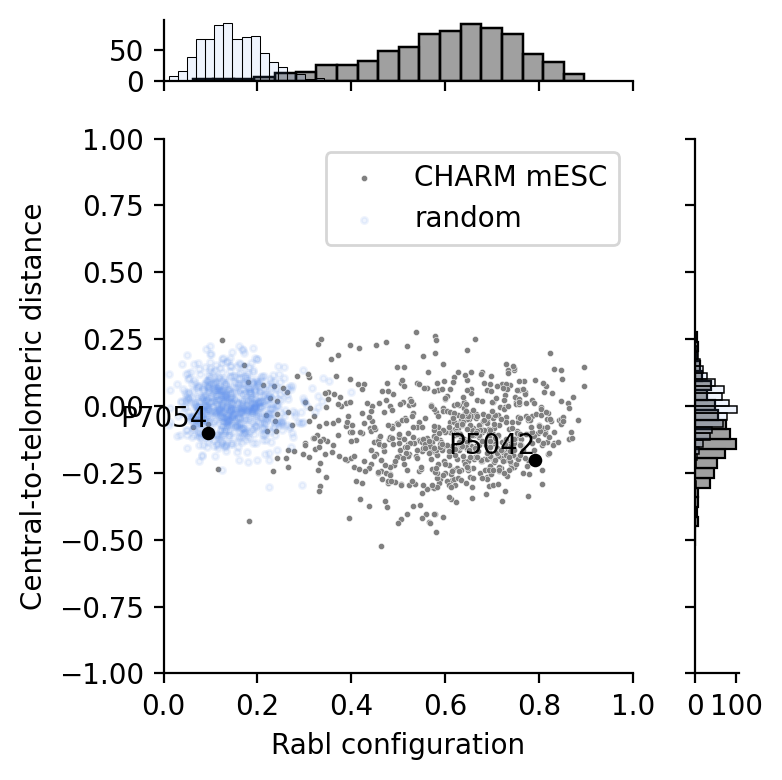

In [24]:
main_data_color = 'grey'
random_data_color = 'cornflowerblue'
highlight_color = 'black'

g = sns.jointplot(data=metadata, x="rabl", y="radial", height=4,
                  color=main_data_color,
                  s=5,
                  marginal_ticks=True,
                  label="CHARM mESC"
                  )

g.ax_joint.scatter(metadata['rabl_random'], metadata['radial_random'],
                   color=random_data_color, s=5, alpha=0.1, label='random')

sns.histplot(x=metadata['rabl_random'], ax=g.ax_marg_x,
             color=random_data_color, alpha=0.1, multiple="stack")
sns.histplot(y=metadata['radial_random'], ax=g.ax_marg_y,
             color=random_data_color, alpha=0.1, multiple="stack")

highlight = metadata[metadata['cellname'].isin(['P5042', 'P7054'])]

g.ax_joint.scatter(highlight['rabl'], highlight['radial'],
                   color=highlight_color, s=15, zorder=5)

for i, row in highlight.iterrows():
    g.ax_joint.text(row['rabl'], row['radial'], row['cellname'],
                    fontsize=10, ha='right', va='bottom', color=highlight_color, zorder=6)

g.ax_joint.set_ylabel("Central-to-telomeric distance")
g.ax_joint.set_xlabel("Rabl configuration")

g.ax_joint.set_xlim(0,1)
g.ax_joint.set_ylim(-1,1)

g.ax_joint.legend()

plt.tight_layout()

plt.savefig("figures/mesc_rabl.pdf")

In [39]:
# write example structures
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    cell.tdg['cen_tel'] = cell.tdg.groupby('chrom',observed=False).apply(lambda x: (x['pos'] - x['pos'].min()) / (x['pos'].max() - x['pos'].min())).reset_index(drop=True)
    return cell
cell = _load_cell('P5042', 5000)
# save to cif
cell.write_cif(factor_b = "cen_tel",outputpath = f"cifs/{cell.cellname}.rabl.cif")
# cell = _load_cell('P7054', 5000)
# # save to cif
# cell.write_cif(factor_b = "cen_tel",outputpath = f"cifs/{cell.cellname}.rabl.cif")

Done P5042


In [38]:

import plotly.express as px
fig = px.scatter_3d(cell.get_data().sample(5000), x='x', y='y', z='z',
                    color='cen_tel', color_continuous_scale=px.colors.sequential.Bluered,
                    title=f"{cell.cellname} Rabl configuration",
                    labels={'cen_tel': 'Central-to-telomeric distance'},
                    
                    )

fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),width=800, height=800
                  )
fig


## Compare with bulk matrix

In [3]:
import cooler

In [4]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"/zliu_ssd/CHARM/CHARM_mesc/data/tdg/{cellname}.5k.3dg.gz",
    )
    return cell

cellnames = metadata['cellname'].values
with concurrent.futures.ProcessPoolExecutor(30) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, cellnames, [5000]*len(cellnames)), total=len(cellnames)))

esc = MultiCell3D.MultiCell3D(cells)

100%|██████████| 720/720 [01:06<00:00, 10.89it/s]


In [5]:
clr = cooler.Cooler("./CHARMmesc.structureqcpass.cool")
bonev_clr = cooler.Cooler("/sharec/zliu/archieve/else/research/publicData/Bonev2017/processedData/processed/mcools/ES.balanced.mcool::/resolutions/5000")
mat_raw = clr.matrix(balance=True).fetch('chr4:136000000-138000000')
mat_bonev = bonev_clr.matrix(balance=True).fetch('chr4:136000000-138000000')

In [6]:
%config InlineBackend.figure_format = 'retina'
mat = esc.calc_3dproximity_matrix(genome_coord = 'chr4:136000000-138000000',distance_threshold=2,allele=False)

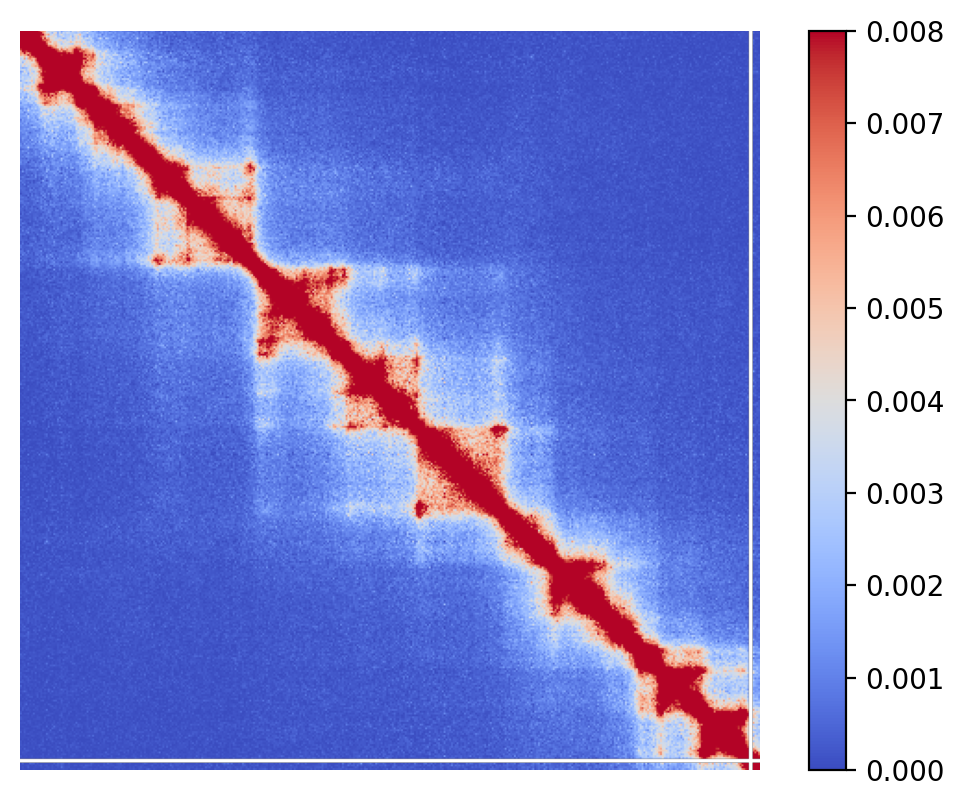

In [7]:
plt.imshow(np.log2(mat_bonev+1),vmin=0,vmax=0.008,cmap='coolwarm')
plt.axis('off')
plt.colorbar()
plt.savefig("figures/bonev_mat.pdf", bbox_inches='tight')

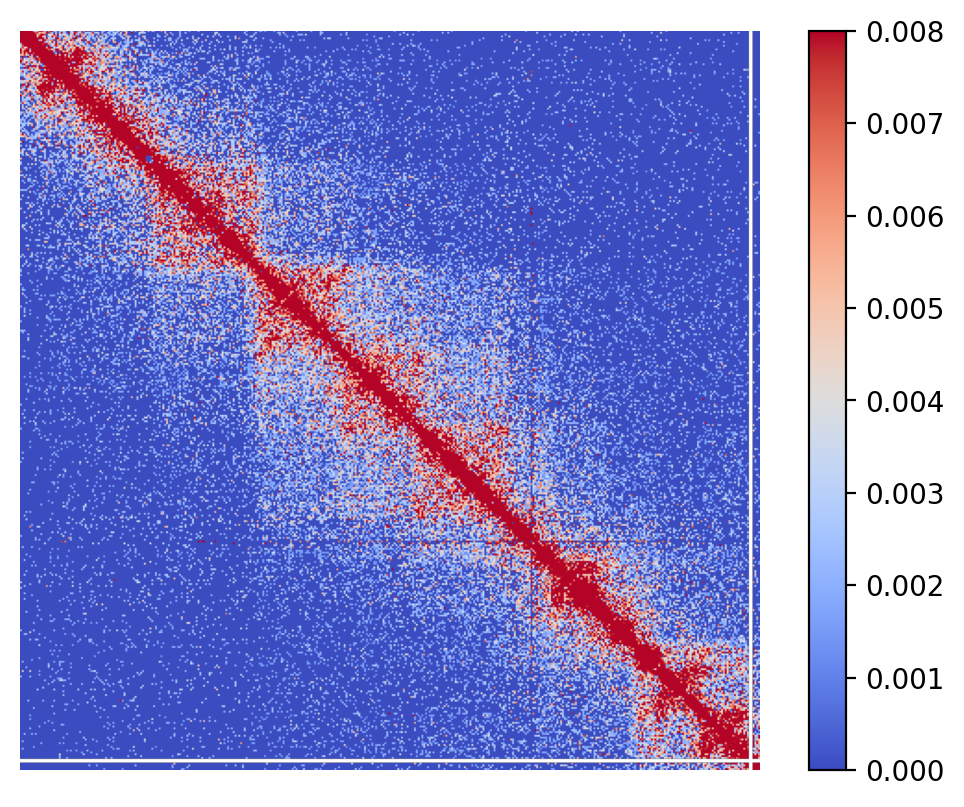

In [8]:
plt.imshow(np.log2(mat_raw+1),vmin=0,vmax=0.008, cmap='coolwarm')
plt.axis('off')
plt.colorbar()
plt.savefig("figures/charmraw_mat.pdf", bbox_inches='tight')

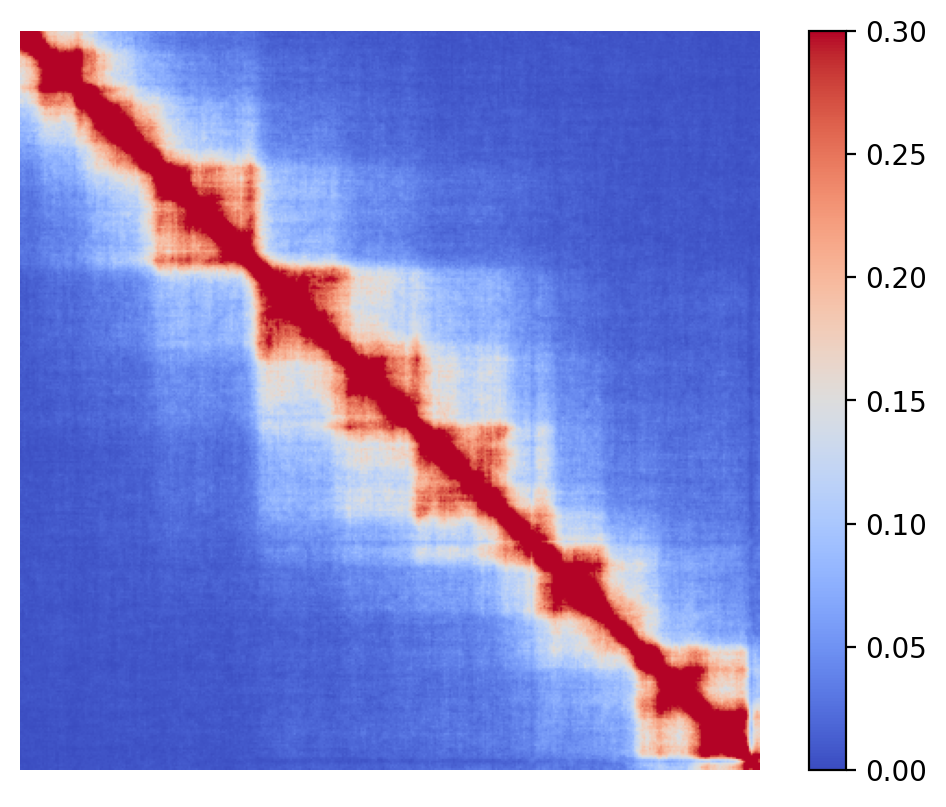

In [9]:
plt.imshow(mat,cmap='coolwarm',vmin=0,vmax=0.3)
plt.axis('off')
plt.colorbar()
plt.savefig("figures/charm3D_mat.pdf", bbox_inches='tight')

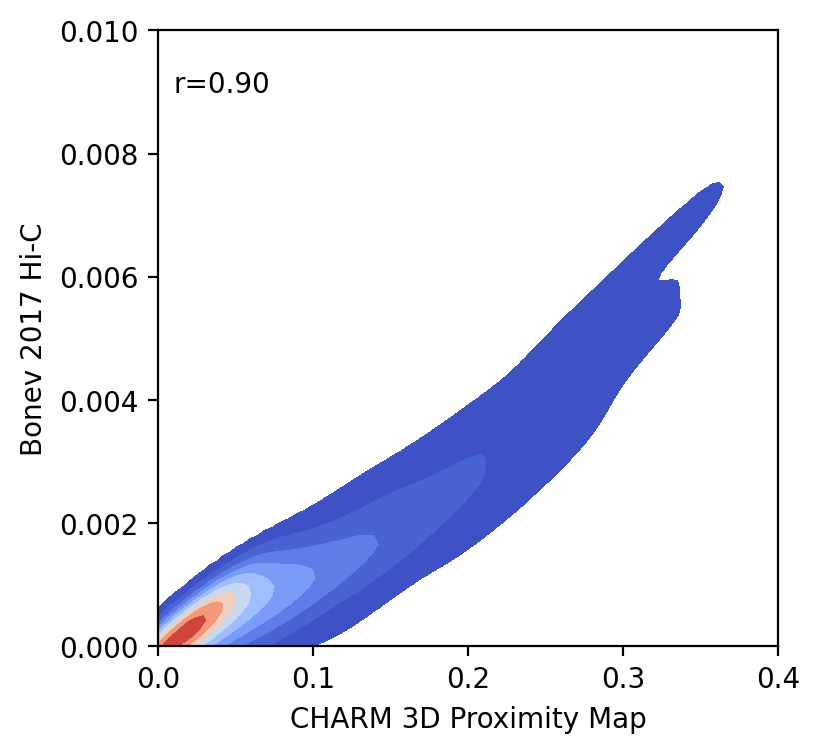

In [10]:
# vectorized triu mat, calculate the correlation with bonev_mat
mat_triu = mat[np.triu_indices(mat.shape[0], k=2)]
mat_bonev_triu = mat_bonev[np.triu_indices(mat_bonev.shape[0], k=2)]
mat_triu = np.nan_to_num(mat_triu)
mat_bonev_triu = np.nan_to_num(mat_bonev_triu)
r, p = stats.spearmanr(mat_triu,mat_bonev_triu)


%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4,4))
# sample 5000 points for plotting
idx = np.random.choice(len(mat_triu), 5000)
mat_triu = mat_triu[idx]
mat_bonev_triu = mat_bonev_triu[idx]
sns.kdeplot(x=mat_triu, y=mat_bonev_triu, cmap='coolwarm', fill=True, levels=10)
# add spearman r to the plot

plt.xlabel("CHARM 3D Proximity Map")
plt.ylabel("Bonev 2017 Hi-C")
plt.text(0.01,0.009,f"r={r:.2f}")
plt.xlim(0,0.4)
plt.ylim(0,0.01)

# save pdf
plt.savefig("figures/CHARM3DvsBonev.pdf", bbox_inches='tight')

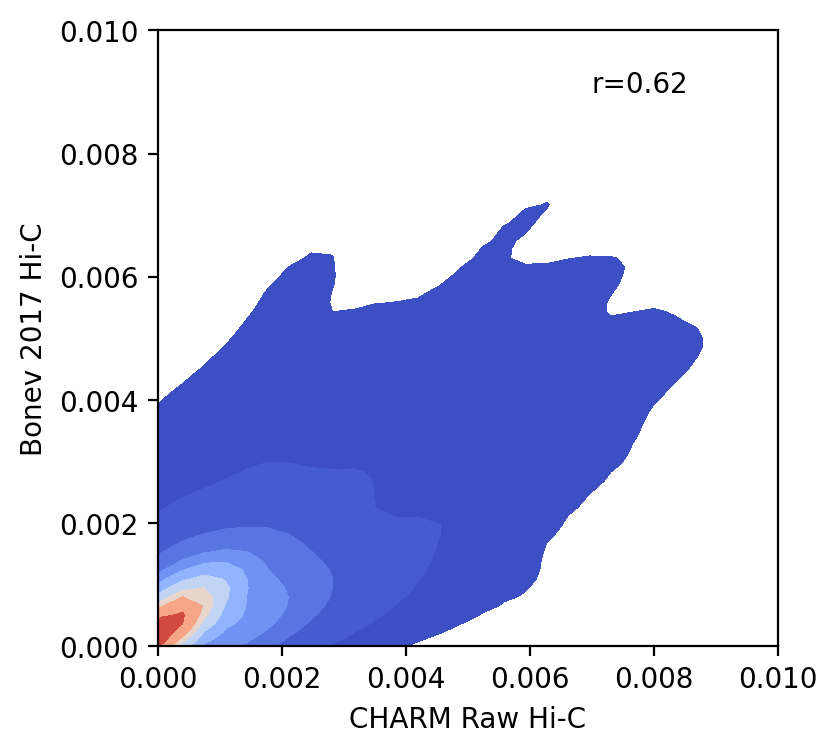

In [11]:
# CHARM rawa vs bonev
mat_raw_triu = mat_raw[np.triu_indices(mat_raw.shape[0], k=2)]
mat_raw_triu = np.nan_to_num(mat_raw_triu)
mat_bonev_triu = mat_bonev[np.triu_indices(mat_bonev.shape[0], k=2)]
mat_bonev_triu = np.nan_to_num(mat_bonev_triu)
r, p = stats.spearmanr(mat_raw_triu,mat_bonev_triu)


%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4,4))
idx = np.random.choice(len(mat_raw_triu), 5000)
mat_raw_triu = mat_raw_triu[idx]
mat_bonev_triu = mat_bonev_triu[idx]

sns.kdeplot(x=mat_raw_triu, y=mat_bonev_triu, cmap='coolwarm', fill=True, levels=10)
plt.xlabel("CHARM Raw Hi-C")
plt.ylabel("Bonev 2017 Hi-C")
plt.text(0.007,0.009,f"r={r:.2f}")
plt.xlim(0,0.01)
plt.ylim(0,0.01)
#plt.show()

plt.savefig("figures/CHARMRawvsBonev.pdf", bbox_inches='tight')

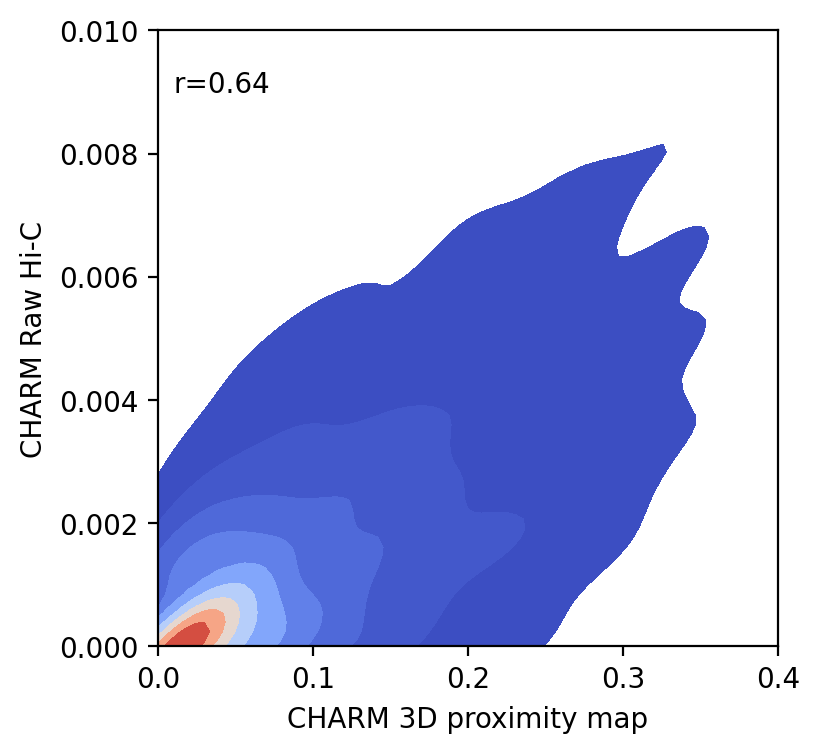

In [12]:
# vectorized triu mat, calculate the correlation with bonev_mat
mat_triu = mat[np.triu_indices(mat.shape[0], k=2)]
mat_raw_triu = mat_raw[np.triu_indices(mat_raw.shape[0], k=2)]
mat_triu = np.nan_to_num(mat_triu)
mat_raw_triu = np.nan_to_num(mat_raw_triu)
r, p = stats.spearmanr(mat_triu,mat_raw_triu)

plt.figure(figsize=(4,4))
# sample 5000 points for plotting
idx = np.random.choice(len(mat_triu), 5000)
mat_triu = mat_triu[idx]
mat_raw_triu = mat_raw_triu[idx]
sns.kdeplot(x=mat_triu, y=mat_raw_triu, cmap='coolwarm', fill=True, levels=10)
# add spearman r to the plot

plt.xlabel("CHARM 3D proximity map")
plt.ylabel("CHARM Raw Hi-C")
plt.text(0.01,0.009,f"r={r:.2f}")
plt.xlim(0,0.4)
plt.ylim(0,0.01)

plt.savefig("figures/CHARMRawvsCHARM3D.pdf", bbox_inches='tight')

In [13]:
# generate 20 random 2mb region for statistics
chrlen = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.len", sep='\t', header=None, names=['chrom', 'length'])

In [14]:
import random

region_size = 2_000_000 
rounding_base = 100_000  

random_regions = []
random.seed(42)
np.random.seed(42)
for _ in range(20):
    random_chrom_series = chrlen.sample(n=1, weights='length').iloc[0]
    chrom_name = random_chrom_series['chrom']
    chrom_length = random_chrom_series['length']
    if chrom_length < region_size:
        continue
    max_start_pos = chrom_length - region_size
    start_pos = (random.randint(0, max_start_pos) // rounding_base) * rounding_base
    end_pos = start_pos + region_size
    formatted_region = f"{chrom_name}:{start_pos}-{end_pos}"
    random_regions.append(formatted_region)

    

In [15]:
spearmanr_charmraw_bonev = []
spearmanr_charm3d_bonev = []
spearmanr_charmraw_charm3d = []

for region in tqdm.tqdm(random_regions):
    mat_raw = clr.matrix(balance=True).fetch(region)
    mat_bonev = bonev_clr.matrix(balance=True).fetch(region)
    mat = esc.calc_3dproximity_matrix(genome_coord=region, distance_threshold=2, allele=False)

    mat_triu = mat[np.triu_indices(mat.shape[0], k=2)]
    mat_raw_triu = mat_raw[np.triu_indices(mat_raw.shape[0], k=2)]
    mat_bonev_triu = mat_bonev[np.triu_indices(mat_bonev.shape[0], k=2)]
    mat_triu = np.nan_to_num(mat_triu)
    mat_raw_triu = np.nan_to_num(mat_raw_triu)
    mat_bonev_triu = np.nan_to_num(mat_bonev_triu)

    r_charmraw_bonev, _ = stats.spearmanr(mat_raw_triu, mat_bonev_triu)
    r_charm3d_bonev, _ = stats.spearmanr(mat_triu, mat_bonev_triu)
    r_charmraw_charm3d, _ = stats.spearmanr(mat_raw_triu, mat_triu)
    
    spearmanr_charmraw_bonev.append(r_charmraw_bonev)
    spearmanr_charm3d_bonev.append(r_charm3d_bonev)
    spearmanr_charmraw_charm3d.append(r_charmraw_charm3d)


 55%|█████▌    | 11/20 [15:56<12:57, 86.43s/it]/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|██████████| 20/20 [29:00<00:00, 87.02s/it]


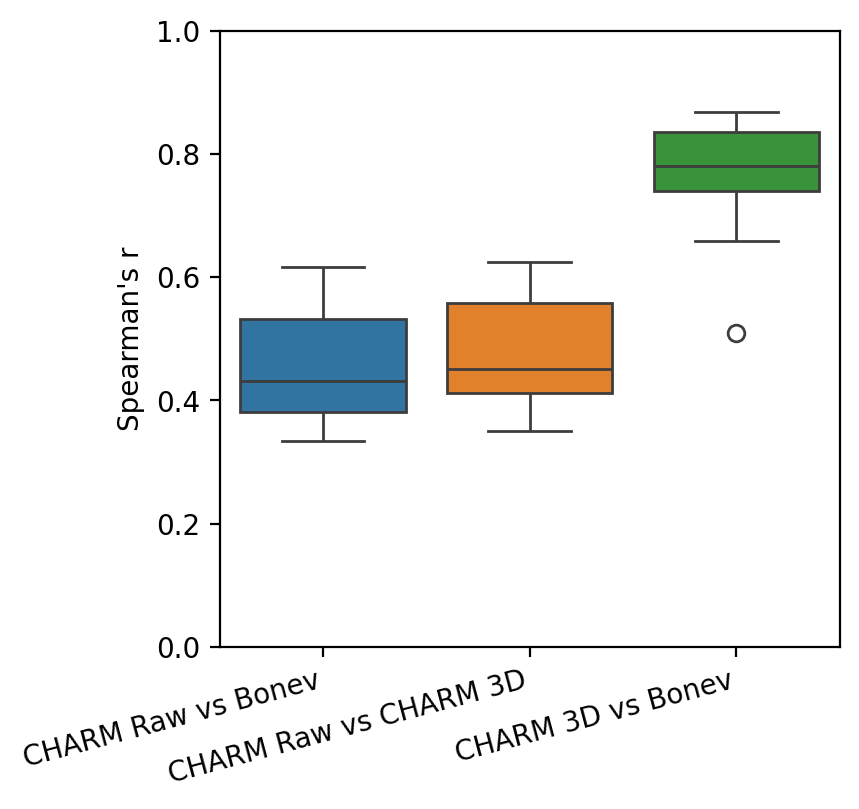

In [16]:
# boxplot of spearmanr values
plt.figure(figsize=(4, 4))
sns.boxplot(data=[spearmanr_charmraw_bonev, spearmanr_charmraw_charm3d,spearmanr_charm3d_bonev])
plt.xticks([0, 1, 2], ['CHARM Raw vs Bonev', 'CHARM Raw vs CHARM 3D','CHARM 3D vs Bonev'])
plt.ylim(0,1)
plt.xticks(rotation=15,ha="right")
plt.ylabel("Spearman's r")
# save figure
plt.savefig("figures/spearmanr_boxplot.pdf", bbox_inches='tight')

In [26]:
np.nanmean(np.array(spearmanr_charm3d_bonev))


0.7706879607769845

## Write example structures

In [9]:
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2].reset_index(drop=True)

rnag1 = pd.read_csv("../data/RNAmats/counts.gene.genome1.format.tsv.gz",sep='\t')
rnag2 = pd.read_csv("../data/RNAmats/counts.gene.genome2.format.tsv.gz",sep='\t')
genes = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",sep='\t')

def _write_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    # cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    # cell.tdg = cell.get_data(if_dense = True)
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", column_name="atac")
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz", column_name="ct")
    
    cell.add_RNA_data(rnag1 = rnag1, rnag2 = rnag2, genes = genes)

    cell.add_bedGraph_data(
        path=f"/mnt/share/Data/public/ref_genome/mouse_ref/M23/CpG/normal_cpg/M23.CpG.5000.txt",
        column_name="CpG",
        type="all"
    )

    cell.tdg["if_expressed"] = (cell.tdg["UMI"] >= 1).astype(int)

    #cell.add_feature_in_radius(feature="atac",radius=2,type="sum",if_self=True)
    #cell.add_feature_in_radius(feature="ct",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="CpG",radius=2,type="mean",if_self=True)
    #cell.add_feature_in_radius(feature="if_expressed",radius=2,type="sum",if_self=True)

    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")

    #cell.write_cif(factor_b = "if_expressed_sum_in_radius_2",outputpath = f"cifs/{cell.cellname}.rna.cif")
    cell.write_cif(factor_b = "CpG_mean_in_radius_2",outputpath = f"cifs/{cell.cellname}.cpg2pr.cif")
    #cell.write_cif(factor_b = "atac_sum_in_radius_2",outputpath = f"cifs/{cell.cellname}.atac.cif")
    #cell.write_cif(factor_b = "ct_sum_in_radius_2",outputpath = f"cifs/{cell.cellname}.ct.cif")
    #cell_rna = cell.subset(query='UMI >= 1')
    #cell_rna.write_cif(factor_b = "UMI",outputpath = f"cifs/{cell_rna.cellname}.onlyrna.cif")

    return cell


_write_cell("P9016",5000)

Done P9016
CHARMtools Cell3D object v0.2
Cell name: P9016
Resolution: 5000
Features: ['atac', 'ct', 'UMI', 'CpG', 'CpG_mean_in_radius2', 'chrom_length']
Chromatin3DStructure with 990081 records
Object is stored on disk: False
Metadata:
